# Basic usage
This notebook shows the process of finding point of radial mode.

In [1]:
import os
import sys
import xlrd
import warnings

import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.join('..'))

from radial import calculate_metrics

from radial.batchflow import Dataset, FilesIndex, Pipeline, B
from radial.batchflow.models.tf import ResNet

from radial.core import RadialBatch
from radial.core import calculate_results
from radial.pipelines import create_preprocess_pipeline,\
                             create_train_pipeline,\
                             create_predict_pipeline
from radial.preprocessing import drop_outliers, xls_to_npz

warnings.filterwarnings("ignore")
plt.style.use('ggplot')
%matplotlib inline

## 1. Preprocessing.
#### 1.1. Raw data to NPZ.

Files with train/test split

In [2]:
xls_to_npz(path_from=['./test_90.xlsx', './train_311.xlsx'],
           path_to=['./data_splited/test', './data_splited/train'])

Done!


The same files without splitting

In [3]:
xls_to_npz(path_from=['./test_90.xlsx', './train_311.xlsx'],
           path_to=['./data'])

Done!


## 1.2. Removing outliers.
We are dropping the outliers using Isolation Forest algorithm. ```path_from``` is a path to data you want to filter out. ```path_to``` is a path where result will be saved.

In [4]:
drop_outliers(path_from=['data_splited/train', 'data_splited/test'],
              path_to=['data_splited/train_isol', 'data_splited/test_isol'], rewrite=True)

100%|██████████| 90/90 [00:13<00:00,  6.35it/s]

Done!


## 2. Training process

Config creation:

In [5]:
N_SAMPLES = 100

model_config = {
    'inputs': dict(points=dict(shape=(N_SAMPLES, 2)),
                   targets=dict(name='target', shape=1)),
    'initial_block/inputs': 'points',
    'head': dict(layout='f',
                 units=1),
    'body/num_blocks': [1, 1, 1],
    'body/filters': [2, 4, 8],
    'initial_block/filters': 8,
    'loss': 'mse',
    'optimizer': 'Adam'
}

Load the data and create Dataset objects.

In [6]:
ds_train = Dataset(FilesIndex(path="./data_splited/train_isol/*"), batch_class=RadialBatch)
ds_test = Dataset(FilesIndex(path="./data_splited/test_isol/*"), batch_class=RadialBatch)

Create two pipelines and run training process

In [7]:
prep_pipeline = create_preprocess_pipeline(N_SAMPLES, np.random.random)
train_pipeline = create_train_pipeline(ResNet, model_config, prep_pipeline) << ds_train

In [8]:
train_pipeline.run(50, n_epochs=300, drop_last=True, shuffle=True, bar=True)

  0%|          | 0/1800 [00:00<?, ?it/s]

env: CUDA_VISIBLE_DEVICES=2


100%|██████████| 1800/1800 [12:43<00:00,  2.56it/s]


## 3. Evaluation
Firstly create a predict pipeline and run it

In [9]:
test_pipeline = create_predict_pipeline(prep_pipeline, train_pipeline) << ds_test

In [10]:
test_pipeline.run(1, n_epochs=10, drop_last=True, bar=True)

100%|█████████▉| 899/900 [00:13<00:00, 64.99it/s]


Calculate statistics and plot the histogram of MAPE error.

In [11]:
results, _ = calculate_results(test_pipeline)

In [12]:
true = []
pred = []
for key in results.keys():
    results[key]['pred'] = np.mean(results[key]['pred'])
    true.append(results[key]['true'][0])
    pred.append(results[key]['pred'])

MAE: 0.1613
MAPE: 0.1084
Percentage of error less than 30%: 93.33%


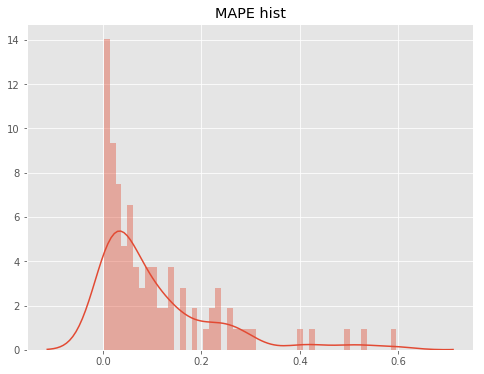

In [13]:
calculate_metrics(np.array(true), np.array(pred), 50)